# EMO: PREPARE DATA
## ACL 2023 Conference
## WASSA 2023 Shared Task on Empathy, Emotion, and Personality Detection in Interactions
More details [here](https://codalab.lisn.upsaclay.fr/competitions/11167#learn_the_details)

In [1]:
import numpy as np
import pandas as pd
import re, os
import ftfy
import pycld2 as cld2
import time
from typing import List
from copy import deepcopy
import spacy
import pkg_resources
from symspellpy import SymSpell, Verbosity
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
#os.path.join()

2023-05-13 19:14:44.046948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
multi_spaces = re.compile('\s{2,}')

def clean_text(s):
    if not isinstance(s, str):
        return s
    for char in ['�', '•']:
        if char in s:
            s = s.replace(char, ' ')
    s = ftfy.fix_text(s)
    
    #s = clean.sub(' ', s.lower())
    s = s.replace('\n', ' ')
    s = multi_spaces.sub(' ', s)
        
    return s.strip()

In [3]:
def detect_lang( t ):
    '''
        Return the language(s) in string s.
        Naive Bayes classifier under the hood -
        results are less certain for strings that are too short.
        Returns up to three languages with confidence scores.
        More on usage: https://pypi.org/project/pycld2/
    '''
    _, _, details = cld2.detect( ftfy.fix_text( t ) )
    return details[0][0]

In [4]:
def get_target(emotions: List[str])->List[int]:
    '''
        Convert list of strings with categories into list of 0s and 1s with length 8 because there are 8 categories;
        1 in the i-th position means that this essay belongs to the i-th category as in key2label[i]
    '''
    res  = [0]*8
    idxs = [label2key[e] for e in emotions]    
    for idx in idxs:
        res[idx] = 1
    return res

In [5]:
# target variables
label2key = {   
    'Anger':    0,
    'Disgust':  1,
    'Fear':     2,
    'Hope':     3,    
    'Joy':      4,
    'Neutral':  5,
    'Sadness':  6,
    'Surprise': 7,
}
key2label = {v: k for k,v in label2key.items()}
print(key2label)

{0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Hope', 4: 'Joy', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}


In [6]:
random_state = 47

## LOAD DATA
### a) Training set

In [7]:
# project files
wdir  = 'data'
files = [ 'WASSA23_essay_level_with_labels_train.tsv', 'WASSA23_essay_level_dev.tsv',
          'WASSA23_conv_level_with_labels_train.tsv', 'WASSA23_conv_level_dev.tsv',
          'articles_adobe_AMT.csv', 'goldstandard_CONV_dev.tsv', 'goldstandard_dev.tsv', ]

# only columns of interest
# put similar columns together
cols_train = [ 'article_id', 'conversation_id', 'speaker_number', 'essay_id', 'speaker_id',
               'essay', 'essay_clean', 'split', 'gender', 'education', 'race', 'age', 'income', 'emotion',
             ]

In [8]:
df_train = pd.read_csv( os.path.join(wdir, files[0]), sep='\t' )
df_train['essay_clean'] = df_train['essay'].apply(clean_text)
df_train['emotion'] = df_train['emotion'].apply( lambda x: x.split('/'))
df_train = df_train[cols_train]

print(df_train.shape, '\n')
print(df_train.dtypes, '\n')
print(df_train.isna().sum(), 'n')

print('\nTotal essays: ', df_train.shape[0])
print('Unique essays:', len(df_train['essay_clean'].unique()))
df_train.head(25)

(792, 14) 

article_id          int64
conversation_id     int64
speaker_number      int64
essay_id            int64
speaker_id          int64
essay              object
essay_clean        object
split              object
gender             object
education          object
race               object
age                object
income             object
emotion            object
dtype: object 

article_id         0
conversation_id    0
speaker_number     0
essay_id           0
speaker_id         0
essay              0
essay_clean        0
split              0
gender             0
education          0
race               0
age                0
income             0
emotion            0
dtype: int64 n

Total essays:  792
Unique essays: 792


,article_id,conversation_id,speaker_number,essay_id,speaker_id,essay,essay_clean,split,gender,education,race,age,income,emotion
0,35,2,1,1,30,It breaks my heart to see people living in tho...,It breaks my heart to see people living in tho...,train,1,6,3,37,40000,"[Hope, Sadness]"
1,35,3,1,2,19,I wonder why there aren't more people trying t...,I wonder why there aren't more people trying t...,train,1,6,2,32,35000,[Anger]
2,35,5,1,4,17,"After reading the article, you can't help but ...","After reading the article, you can't help but ...",train,1,6,1,29,85000,[Sadness]
3,213,6,1,5,16,It is so sad that someone who had such an amaz...,It is so sad that someone who had such an amaz...,train,2,5,1,28,50000,[Sadness]
4,213,8,1,7,30,"From reading the article, it looks like the wo...","From reading the article, it looks like the wo...",train,1,6,3,37,40000,[Neutral]
5,213,10,1,9,49,That's sad. Regardless of what they find out ...,That's sad. Regardless of what they find out h...,train,1,5,1,31,82000,[Sadness]
6,78,11,1,10,17,"After reading the article, my reaction is that...","After reading the article, my reaction is that...",train,1,6,1,29,85000,[Sadness]
7,78,13,1,12,24,It sounds like these boys had a really rough l...,It sounds like these boys had a really rough l...,train,2,7,1,38,42000,[Sadness]
8,78,14,1,13,43,This is a tragic and sad story about how some ...,This is a tragic and sad story about how some ...,train,2,6,1,33,110000,[Sadness]
9,336,17,1,16,31,Hello. I feel really terrible about the curren...,Hello. I feel really terrible about the curren...,train,unknown,unknown,unknown,unknown,unknown,"[Disgust, Sadness]"


__Based on the above stats, there are no duplicate essays, no NaN values, but there is missing data in the form of a string instead of a numerical value - the presence of `unknown` in some numerical columns changes their type from `integer` / `float` to `object`__

In [10]:
# binarize my way
df_train['target_encoded'] = df_train['emotion'].apply(get_target)

# binarize the scikit learn way
mlb = MultiLabelBinarizer()
df_train['target_encoded2'] = mlb.fit_transform(df_train['emotion'].tolist()).tolist()

# both ways are identical if alphabetical order
df_train['compare'] = df_train['target_encoded'] == df_train['target_encoded2']
print(df_train['compare'].value_counts())

df_train.head(25)

True    792
Name: compare, dtype: int64


,article_id,conversation_id,speaker_number,essay_id,speaker_id,essay,essay_clean,split,gender,education,race,age,income,emotion,target_encoded,target_encoded2,compare
0,35,2,1,1,30,It breaks my heart to see people living in tho...,It breaks my heart to see people living in tho...,train,1,6,3,37,40000,"[Hope, Sadness]","[0, 0, 0, 1, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 1, 0]",True
1,35,3,1,2,19,I wonder why there aren't more people trying t...,I wonder why there aren't more people trying t...,train,1,6,2,32,35000,[Anger],"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",True
2,35,5,1,4,17,"After reading the article, you can't help but ...","After reading the article, you can't help but ...",train,1,6,1,29,85000,[Sadness],"[0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0]",True
3,213,6,1,5,16,It is so sad that someone who had such an amaz...,It is so sad that someone who had such an amaz...,train,2,5,1,28,50000,[Sadness],"[0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0]",True
4,213,8,1,7,30,"From reading the article, it looks like the wo...","From reading the article, it looks like the wo...",train,1,6,3,37,40000,[Neutral],"[0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0]",True
5,213,10,1,9,49,That's sad. Regardless of what they find out ...,That's sad. Regardless of what they find out h...,train,1,5,1,31,82000,[Sadness],"[0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0]",True
6,78,11,1,10,17,"After reading the article, my reaction is that...","After reading the article, my reaction is that...",train,1,6,1,29,85000,[Sadness],"[0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0]",True
7,78,13,1,12,24,It sounds like these boys had a really rough l...,It sounds like these boys had a really rough l...,train,2,7,1,38,42000,[Sadness],"[0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0]",True
8,78,14,1,13,43,This is a tragic and sad story about how some ...,This is a tragic and sad story about how some ...,train,2,6,1,33,110000,[Sadness],"[0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0]",True
9,336,17,1,16,31,Hello. I feel really terrible about the curren...,Hello. I feel really terrible about the curren...,train,unknown,unknown,unknown,unknown,unknown,"[Disgust, Sadness]","[0, 1, 0, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0, 1, 0]",True


__MultiLabelBinarizer()__ works exactly as my method as long as the labels are sorted alphabetically

In [11]:
# get classes, convert back - np.array(list) is the only way
print(mlb.classes_)
mlb.inverse_transform( np.array(df_train['target_encoded2'].tolist()) )[:10]

['Anger' 'Disgust' 'Fear' 'Hope' 'Joy' 'Neutral' 'Sadness' 'Surprise']


[('Hope', 'Sadness'),
 ('Anger',),
 ('Sadness',),
 ('Sadness',),
 ('Neutral',),
 ('Sadness',),
 ('Sadness',),
 ('Sadness',),
 ('Sadness',),
 ('Disgust', 'Sadness')]

#### Two labels stats

In [9]:
# total label count (not exploding)
df_train.explode('emotion')['emotion'].value_counts()

Sadness     383
Neutral     240
Anger       124
Disgust     100
Fear         33
Hope         32
Surprise     19
Joy          10
Name: emotion, dtype: int64

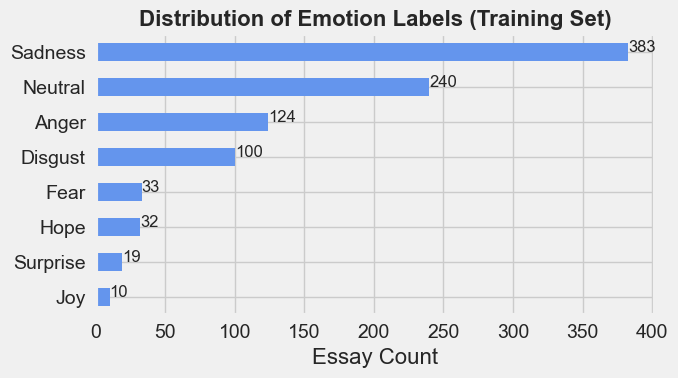

In [24]:
import matplotlib
matplotlib.style.use('fivethirtyeight')    #'seaborn', fivethirtyeight
plt.figure( figsize=(7,4))
s = df_train.explode('emotion')['emotion'].value_counts().sort_values()
ax = s.plot(kind='barh', color='cornflowerblue')
[ax.text(v, i, v, fontsize=12) for i, v in enumerate(s)]
plt.title('Distribution of Emotion Labels (Training Set)', fontweight='bold', fontsize=16)
plt.xlabel('Essay Count', fontsize=16)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

In [14]:
df_train['emotion_count'] = df_train['emotion'].apply( lambda x: len(x) )
df_train['emotion_count'].value_counts()

1    644
2    147
3      1
Name: emotion_count, dtype: int64

In [15]:
# the only case with three labels
print(df_train[ df_train['emotion_count']==3 ]['essay'].tolist())
df_train[ df_train['emotion_count']==3 ]

["It's the 21st century and we have barely moved women.   USA has slipped to 45th and we have African countries ahead of us.   For the past 100 years, it's all politics and government and who is going to win.  Definitely not for equality or fairness to genders.  I had a job in career that compared identically to a man's and he was paid 40% more than me.   You can't express it or you get fire because almost every state is an at-will state."]


,article_id,conversation_id,speaker_number,essay_id,speaker_id,essay,essay_clean,split,gender,education,race,age,income,emotion,target_encoded,target_encoded2,compare,emotion_count
321,331,410,1,409,8,It's the 21st century and we have barely moved...,It's the 21st century and we have barely moved...,train,2,6,1,62,29000,"[Anger, Disgust, Sadness]","[1, 1, 0, 0, 0, 0, 1, 0]","[1, 1, 0, 0, 0, 0, 1, 0]",True,3


In [16]:
double_categories = df_train[ df_train['emotion_count']==2 ]['emotion'].tolist()
print(len(double_categories))
sorted(double_categories)

147


[['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Fear'],
 ['Anger', 'Hope'],
 ['Anger', 'Joy'],
 ['Anger', 'Neutral'],
 ['Anger', 'Neutral'],
 ['Anger', 'Neutral'],
 ['Anger', 'Neutral'],
 ['Anger', 'Neutral'],
 ['Anger', 'Neutral'],
 ['Anger', 'Neutral'],
 ['Anger', 'Neutral'],
 ['Anger', 'Sadness'],
 ['Anger', 'Sadness'],
 ['Anger', 'Sadness'],
 ['Anger', 'Sadness'],
 ['Anger', 'Sadness']

__How can there be (ANGER, NEUTRAL) or (NEUTRAL, SADNESS) at the same time?!__

In [18]:
# label distribution in the essays with two labels
c = Counter([item for sublist in double_categories for item in sublist])
c.most_common()

[('Sadness', 85),
 ('Anger', 56),
 ('Disgust', 55),
 ('Neutral', 38),
 ('Fear', 23),
 ('Hope', 22),
 ('Surprise', 10),
 ('Joy', 5)]

#### Length of essays

In [26]:
df_train['char_length'] = df_train['essay'].apply( lambda x: len(x) )
df_train['word_length'] = df_train['essay'].apply( lambda x: len(x.split()) )

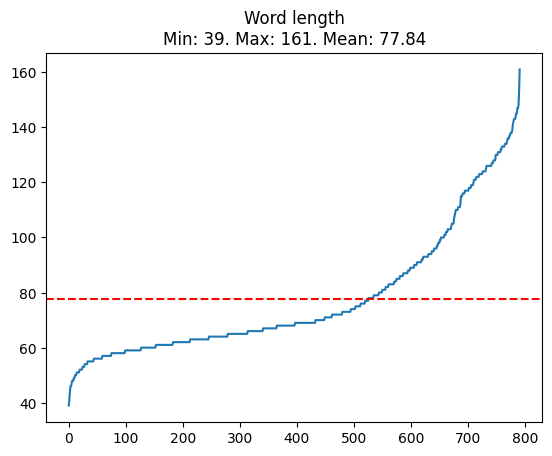

In [20]:
mean_value = round(df_train['word_length'].mean(), 2)
title = 'Word length\n' +\
f"Min: {df_train['word_length'].min()}. Max: {df_train['word_length'].max()}. Mean: {mean_value}"
plt.plot(sorted(df_train['word_length'].values))
plt.axhline(y=mean_value, color='r', linestyle='--')
plt.title(title)
plt.show()

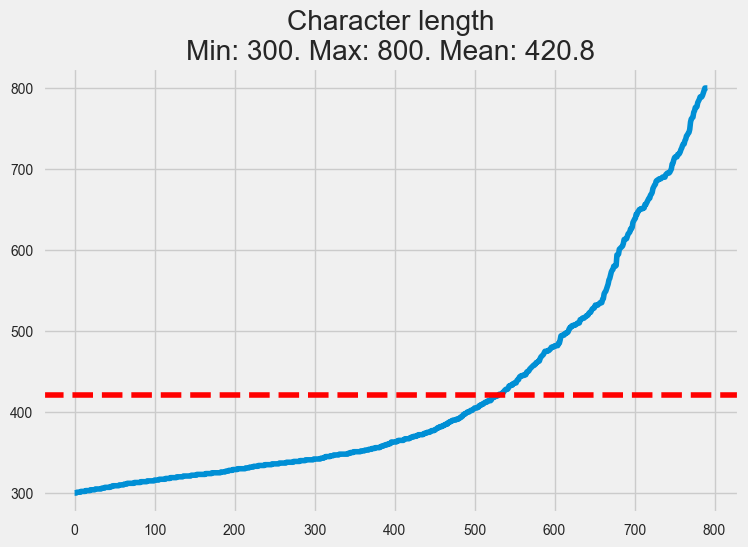

In [27]:
mean_value = round(df_train['char_length'].mean(), 2)
title = 'Character length\n' +\
f"Min: {df_train['char_length'].min()}. Max: {df_train['char_length'].max()}. Mean: {mean_value}"
plt.plot(sorted(df_train['char_length'].values))
plt.axhline(y=mean_value, color='r', linestyle='--')
plt.title(title)
plt.show()

In [22]:
# approx. total number of tokens and ChatGPT batches
len(' '.join(df_train['essay'].tolist()).split()), 70000/4096

(61650, 17.08984375)

### b) Dev

In [28]:
# only columns of interest
cols_dev = [ 'article_id', 'conversation_id', 'speaker_number', 'essay_id', 'speaker_id',
             'essay', 'essay_clean', 'split', 'gender', 'education', 'race', 'age', 'income', ]
len(cols_dev)

13

In [29]:
df_dev = pd.read_csv( os.path.join(wdir, files[1]), sep='\t' )
df_dev['essay_clean'] = df_dev['essay'].apply(clean_text)
df_dev = df_dev[cols_dev]

print(df_dev.shape, '\n')
print(df_dev.dtypes, '\n')
print(df_dev.isna().sum(), 'n')

print('\nTotal essays: ', df_dev.shape[0])
print('Unique essays:', len(df_dev['essay_clean'].unique()))

df_dev.head(25)

(208, 13) 

article_id          int64
conversation_id     int64
speaker_number      int64
essay_id            int64
speaker_id          int64
essay              object
essay_clean        object
split              object
gender              int64
education           int64
race                int64
age                 int64
income              int64
dtype: object 

article_id         0
conversation_id    0
speaker_number     0
essay_id           0
speaker_id         0
essay              0
essay_clean        0
split              0
gender             0
education          0
race               0
age                0
income             0
dtype: int64 n

Total essays:  208
Unique essays: 208


,article_id,conversation_id,speaker_number,essay_id,speaker_id,essay,essay_clean,split,gender,education,race,age,income
0,35,1,1,0,68,How sad is it that this kind of pain and suffe...,How sad is it that this kind of pain and suffe...,dev,2,2,1,21,20000
1,35,4,1,3,79,The article is kind of tragic and hits close t...,The article is kind of tragic and hits close t...,dev,1,6,3,33,64000
2,213,7,1,6,68,"I think that these kinds of stories, are sad, ...","I think that these kinds of stories, are sad, ...",dev,2,2,1,21,20000
3,213,9,1,8,84,It's crazy that random accidents like this hap...,It's crazy that random accidents like this hap...,dev,2,4,1,25,55000
4,78,12,1,11,68,This story makes me so so sad.... As someone w...,This story makes me so so sad.... As someone w...,dev,2,2,1,21,20000
5,78,15,1,14,70,"After reading the article, my first reaction a...","After reading the article, my first reaction a...",dev,1,6,1,29,85000
6,336,16,1,15,81,I didn't know coal mining had such adverse eff...,I didn't know coal mining had such adverse eff...,dev,1,4,1,30,27000
7,336,20,1,19,73,This is very sad. I can't imagine having elep...,This is very sad. I can't imagine having eleph...,dev,2,7,1,38,42000
8,281,23,1,22,63,"Guys, reading this article really hits home fo...","Guys, reading this article really hits home fo...",dev,1,4,1,25,29000
9,171,26,1,25,63,Hey guys. So I just read this article about Ir...,Hey guys. So I just read this article about Ir...,dev,1,4,1,25,29000


__No duplicate essays or missing / NaN values__

### c) Gold

In [30]:
colnames=[ 'empathy', 'distress', 'emotion', 'personality_conscientiousness', 'personality_openess',
           'personality_extraversion', 'personality_agreeableness',
           'personality_stability', 'iri_perspective_taking',
           'iri_personal_distress', 'iri_fantasy', 'iri_empathatic_concern', ] 
print(len(colnames))
df_gold = pd.read_csv( os.path.join(wdir, files[6]), names=colnames, sep='\t')
print(df_dev.shape, '\n')
print(df_gold.shape, '\n')
print(df_gold.isna().sum(), '\n')
print(df_gold.dtypes, '\n')
df_gold.head(25)

12
(208, 13) 

(208, 12) 

empathy                          0
distress                         0
emotion                          0
personality_conscientiousness    0
personality_openess              0
personality_extraversion         0
personality_agreeableness        0
personality_stability            0
iri_perspective_taking           0
iri_personal_distress            0
iri_fantasy                      0
iri_empathatic_concern           0
dtype: int64 

empathy                          float64
distress                         float64
emotion                           object
personality_conscientiousness    float64
personality_openess              float64
personality_extraversion         float64
personality_agreeableness        float64
personality_stability            float64
iri_perspective_taking           float64
iri_personal_distress            float64
iri_fantasy                      float64
iri_empathatic_concern           float64
dtype: object 



,empathy,distress,emotion,personality_conscientiousness,personality_openess,personality_extraversion,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern
0,3.833333,3.375,Sadness,5.00,3.00,5.00,4.00,3.5,2.714,3.0000,3.143,3.286
1,3.000000,1.000,Sadness,6.50,7.00,3.50,4.50,7.0,3.714,1.0000,2.429,1.429
2,3.833333,4.250,Sadness,5.00,3.00,5.00,4.00,3.5,2.714,3.0000,3.143,3.286
3,3.166667,2.375,Neutral,5.50,5.50,3.50,4.50,4.0,3.571,2.8570,3.571,3.143
4,3.333333,3.500,Sadness,5.00,3.00,5.00,4.00,3.5,2.714,3.0000,3.143,3.286
5,1.500000,1.500,Sadness,6.75,6.75,6.75,6.75,7.0,4.643,2.0715,4.143,4.643
6,6.000000,6.000,Neutral,3.00,4.00,6.00,6.00,6.5,3.429,2.8570,4.571,4.000
7,2.500000,1.000,Sadness,7.00,3.50,6.50,5.50,6.5,3.429,2.7140,2.571,3.857
8,4.000000,5.500,Sadness,6.00,6.00,5.50,6.50,3.0,4.857,3.1430,2.571,4.857
9,3.666667,2.250,Neutral,6.00,6.00,5.50,6.50,3.0,4.857,3.1430,2.571,4.857


### d) Merge dev and gold and check for data leakage

In [31]:
df_dev['emotion'] = df_gold['emotion'].values
df_dev['emotion'] = df_dev['emotion'].apply( lambda x: x.split('/'))

# not exploding
df_dev.explode('emotion')['emotion'].value_counts()

Sadness     101
Neutral      54
Anger        38
Disgust      24
Hope         16
Fear          8
Surprise      3
Joy           2
Name: emotion, dtype: int64

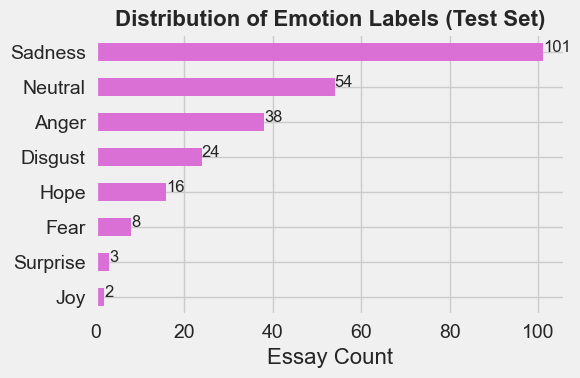

In [34]:
plt.figure( figsize=(6,4))
s = df_dev.explode('emotion')['emotion'].value_counts().sort_values()
ax = s.plot(kind='barh', color='orchid')
[ax.text(v, i, v, fontsize=12) for i, v in enumerate(s)]
plt.title('Distribution of Emotion Labels (Test Set)', fontweight='bold', fontsize=16)
plt.xlabel('Essay Count', fontsize=16)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

In [36]:
df_dev['char_length'] = df_dev['essay'].apply( lambda x: len(x) )
df_dev['word_length'] = df_dev['essay'].apply( lambda x: len(x.split()) )

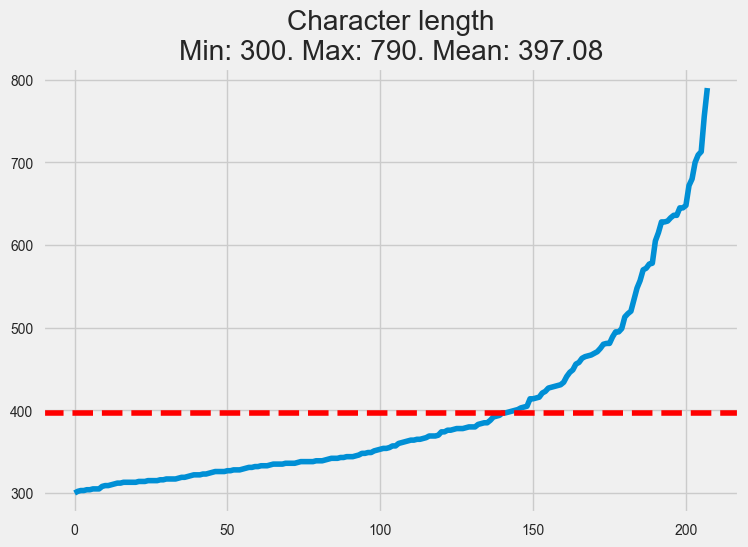

In [37]:
mean_value = round(df_dev['char_length'].mean(), 2)
title = 'Character length\n' +\
f"Min: {df_dev['char_length'].min()}. Max: {df_dev['char_length'].max()}. Mean: {mean_value}"
plt.plot(sorted(df_dev['char_length'].values))
plt.axhline(y=mean_value, color='r', linestyle='--')
plt.title(title)
plt.show()

In [27]:
# any overlap with training set (data leakage)?
overlap = list(set([ i for i in df_train['essay_clean'].values if i in df_dev['essay_clean'].values ]))
df_train[ df_train['essay_clean'].isin(overlap) ]

,article_id,conversation_id,speaker_number,essay_id,speaker_id,essay,essay_clean,split,gender,education,race,age,income,emotion,target_encoded,target_encoded2,compare,emotion_count,char_length,word_length
746,7,443,2,942,30,Living in a war tore country must be horrible....,Living in a war tore country must be horrible....,train,1,6,3,37,40000,"[Hope, Sadness]","[0, 0, 0, 1, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 1, 0]",True,2,325,66


In [28]:
df_dev[ df_dev['essay_clean'].isin(overlap) ]

,article_id,conversation_id,speaker_number,essay_id,speaker_id,essay,essay_clean,split,gender,education,race,age,income,emotion
197,11,449,2,948,75,Living in a war tore country must be horrible....,Living in a war tore country must be horrible....,dev,1,6,3,37,40000,[Sadness]


* Exactly the same essay text
* Different article and essay id
* Different set of labels (one coincides)
* This can definitely cause [small] confusion
* Best solution - there is an element of hope in the train (underreprented category) + the dev set is used to submit the dev results and compare with other particiapnts - keep the overlap in both sets

In [29]:
df_dev['emotion_count'] = df_dev['emotion'].apply( lambda x: len(x) )
df_dev['emotion_count'].value_counts()

1    170
2     38
Name: emotion_count, dtype: int64

In [30]:
double_categories = df_dev[ df_dev['emotion_count']==2 ]['emotion'].tolist()
print(len(double_categories))
sorted(double_categories)

38


[['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Disgust'],
 ['Anger', 'Neutral'],
 ['Anger', 'Sadness'],
 ['Anger', 'Sadness'],
 ['Anger', 'Sadness'],
 ['Anger', 'Sadness'],
 ['Anger', 'Sadness'],
 ['Anger', 'Sadness'],
 ['Anger', 'Sadness'],
 ['Disgust', 'Hope'],
 ['Disgust', 'Sadness'],
 ['Disgust', 'Sadness'],
 ['Disgust', 'Sadness'],
 ['Disgust', 'Sadness'],
 ['Disgust', 'Sadness'],
 ['Fear', 'Sadness'],
 ['Fear', 'Sadness'],
 ['Hope', 'Neutral'],
 ['Hope', 'Neutral'],
 ['Hope', 'Sadness'],
 ['Hope', 'Sadness'],
 ['Hope', 'Sadness'],
 ['Hope', 'Sadness'],
 ['Hope', 'Sadness'],
 ['Hope', 'Sadness'],
 ['Hope', 'Sadness'],
 ['Neutral', 'Sadness'],
 ['Neutral', 'Sadness'],
 ['Neutral', 'Sadness'],
 ['Neutral', 'Surprise'],
 ['Sadness', 'Surprise'],
 ['Sadness', 'Surprise']]

__How can there be (ANGER, NEUTRAL) or (NEUTRAL, SADNESS) at the same time?!__

In [31]:
c = Counter([item for sublist in double_categories for item in sublist])
c.most_common()

[('Sadness', 26),
 ('Anger', 15),
 ('Disgust', 13),
 ('Hope', 10),
 ('Neutral', 7),
 ('Surprise', 3),
 ('Fear', 2)]

#### Length of essays

In [32]:
df_dev['char_length'] = df_dev['essay'].apply( lambda x: len(x) )
df_dev['word_length'] = df_dev['essay'].apply( lambda x: len(x.split()) )

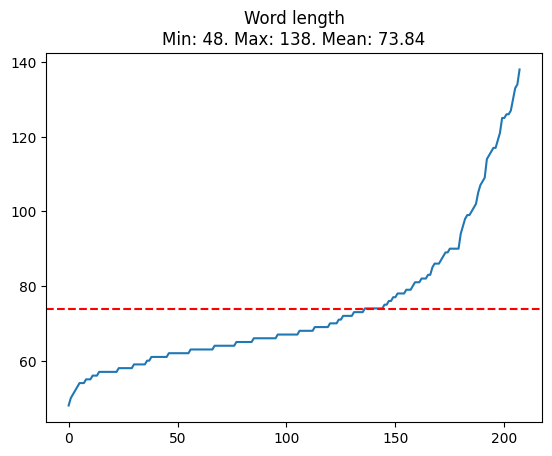

In [33]:
mean_value = round(df_dev['word_length'].mean(), 2)
title = 'Word length\n' +\
f"Min: {df_dev['word_length'].min()}. Max: {df_dev['word_length'].max()}. Mean: {mean_value}"
plt.plot(sorted(df_dev['word_length'].values))
plt.axhline(y=mean_value, color='r', linestyle='--')
plt.title(title)
plt.show()

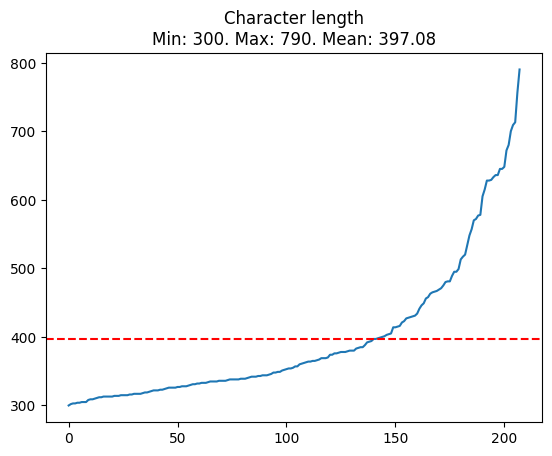

In [34]:
mean_value = round(df_dev['char_length'].mean(), 2)
title = 'Character length\n' +\
f"Min: {df_dev['char_length'].min()}. Max: {df_dev['char_length'].max()}. Mean: {mean_value}"
plt.plot(sorted(df_dev['char_length'].values))
plt.axhline(y=mean_value, color='r', linestyle='--')
plt.title(title)
plt.show()

Character-length numbers match those in the training set approximately. Word-length numbers are slightly different

In [36]:
# approx. total number of tokens and ChatGPT batches
len(' '.join(df_dev['essay'].tolist()).split()), 20000/4096

(15358, 4.8828125)

### e) Prepare target in dev set for classification report

In [38]:
df_dev['target_encoded'] = df_dev['emotion'].apply(get_target)
df_dev.head(25)

,article_id,conversation_id,speaker_number,essay_id,speaker_id,essay,essay_clean,split,gender,education,race,age,income,emotion,emotion_count,char_length,word_length,target_encoded
0,35,1,1,0,68,How sad is it that this kind of pain and suffe...,How sad is it that this kind of pain and suffe...,dev,2,2,1,21,20000,[Sadness],1,339,63,"[0, 0, 0, 0, 0, 0, 1, 0]"
1,35,4,1,3,79,The article is kind of tragic and hits close t...,The article is kind of tragic and hits close t...,dev,1,6,3,33,64000,[Sadness],1,367,63,"[0, 0, 0, 0, 0, 0, 1, 0]"
2,213,7,1,6,68,"I think that these kinds of stories, are sad, ...","I think that these kinds of stories, are sad, ...",dev,2,2,1,21,20000,[Sadness],1,315,57,"[0, 0, 0, 0, 0, 0, 1, 0]"
3,213,9,1,8,84,It's crazy that random accidents like this hap...,It's crazy that random accidents like this hap...,dev,2,4,1,25,55000,[Neutral],1,385,72,"[0, 0, 0, 0, 0, 1, 0, 0]"
4,78,12,1,11,68,This story makes me so so sad.... As someone w...,This story makes me so so sad.... As someone w...,dev,2,2,1,21,20000,[Sadness],1,384,76,"[0, 0, 0, 0, 0, 0, 1, 0]"
5,78,15,1,14,70,"After reading the article, my first reaction a...","After reading the article, my first reaction a...",dev,1,6,1,29,85000,[Sadness],1,380,68,"[0, 0, 0, 0, 0, 0, 1, 0]"
6,336,16,1,15,81,I didn't know coal mining had such adverse eff...,I didn't know coal mining had such adverse eff...,dev,1,4,1,30,27000,[Neutral],1,362,59,"[0, 0, 0, 0, 0, 1, 0, 0]"
7,336,20,1,19,73,This is very sad. I can't imagine having elep...,This is very sad. I can't imagine having eleph...,dev,2,7,1,38,42000,[Sadness],1,363,66,"[0, 0, 0, 0, 0, 0, 1, 0]"
8,281,23,1,22,63,"Guys, reading this article really hits home fo...","Guys, reading this article really hits home fo...",dev,1,4,1,25,29000,[Sadness],1,342,66,"[0, 0, 0, 0, 0, 0, 1, 0]"
9,171,26,1,25,63,Hey guys. So I just read this article about Ir...,Hey guys. So I just read this article about Ir...,dev,1,4,1,25,29000,[Neutral],1,416,74,"[0, 0, 0, 0, 0, 1, 0, 0]"


## Add articles, do spellcheck

In [39]:
# open the articles file
df_art = pd.read_csv( os.path.join(wdir, files[4]), )
print(df_art.shape, '\n')
print('Unique article IDs:', len(df_art['article_id'].unique()), '\n')
print(df_art.isna().sum(), '\n')
print(df_art.dtypes, '\n')
df_art.head(25)

(418, 2) 

Unique article IDs: 418 

article_id    0
text          0
dtype: int64 

article_id     int64
text          object
dtype: object 



,article_id,text
0,1,'Abhorrent' bottle attack on young Rangers fan...
1,2,'Afghan Girl' in iconic National Geographic ph...
2,3,'My whole family has been wiped out': Victims ...
3,4,'RHONY' STAR JULES WAINSTEIN Estranged Husband...
4,5,'Swam for their life': More survivors of Levia...
5,6,"'They Were Just Like Us, and They Lost Everyth..."
6,7,"'This isn't Pompeii, this is Aleppo' — As 200..."
7,8,'This was a sad but avoidable tragedy'; kennel...
8,9,"'Utter devastation' after major quake, aftersh..."
9,10,"1 Police Officer Dead, 1 Wounded After Western..."


In [40]:
def get_article(article_id):
    return df_art[ df_art['article_id']==article_id ]['text'].values[0]

df_train['article']       = df_train['article_id'].apply( get_article )
df_train['article_clean'] = df_train['article'].apply( clean_text )

df_dev['article']         = df_dev['article_id'].apply( get_article )
df_dev['article_clean']   = df_dev['article'].apply( clean_text )

In [41]:
def autocorrect(docs):
    '''
        Apply symspellpy and keep word case and punctuation    
    '''
    for doc in docs:
        res = ''
        for t in doc:
            if t.is_alpha and t.is_oov:
                suggestions = sym_spell.lookup( t.text, Verbosity.TOP, max_edit_distance=2,
                                                include_unknown=True,
                                                transfer_casing=True,)
                corrected_word = suggestions[0].term
                if t.text[0].islower():
                    res += corrected_word
                else:
                    res += corrected_word.capitalize()
                res += t.whitespace_

            else:
                res += t.text_with_ws

        yield res.strip()
        

# load spaCy        
nlp = spacy.load("en_core_web_lg", exclude=['parser', 'ner', 'tagger', 'attribute_ruler', 'lemmatizer'])
print(nlp.pipe_names)

# load symspellpy
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename( "symspellpy", "frequency_dictionary_en_82_765.txt" )
# term_index - column of term; count_index - column of term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
print('Total unique English words:', len(sym_spell.words.keys()))    # this is already a dict: keys=words, values=freqs

# sample usage of symspellpy
input_term = "memebers" 
# max_edit_distance_lookup <= max_dictionary_edit_distance
suggestions = sym_spell.lookup(input_term, Verbosity.CLOSEST, max_edit_distance=2)
print(input_term)
for suggestion in suggestions:
    print(suggestion)

['tok2vec']
Total unique English words: 82834
memebers
members, 1, 226656153


In [42]:
df_train['essay_clean']   = df_train['essay_clean'].str.strip()
df_train['article_clean'] = df_train['article_clean'].str.strip()
df_dev['essay_clean']     = df_dev['essay_clean'].str.strip()
df_dev['article_clean']   = df_dev['article_clean'].str.strip()

In [43]:
def get_var_name(obj):
    '''
        Get the name of variable obj    
    '''
    name =[x for x in globals() if globals()[x] is obj][0]
    return name

cols = [ 'essay_clean', 'article_clean' ]
dfs  = [df_train, df_dev]

for df in dfs:
    for col in cols:
        print(f'Processing dataframe {get_var_name(df)}, column {col}')
        df[col + '_docs'] = list(nlp.pipe( df[col].tolist() ))
        df[col + '_spellchecked'] = list(autocorrect( df[col + '_docs'].tolist() ))

Processing dataframe df_train, column essay_clean
Processing dataframe df_train, column article_clean
Processing dataframe df_dev, column essay_clean
Processing dataframe df_dev, column article_clean


In [44]:
df_train['compare1'] = df_train['essay_clean'] == df_train['essay_clean_spellchecked']
print('df_train, essays:\n', df_train['compare1'].value_counts(), sep='')
df_train['compare2'] = df_train['article_clean'] == df_train['article_clean_spellchecked']
print('\ndf_train, articles:\n', df_train['compare2'].value_counts(), sep='')

df_train, essays:
True     690
False    102
Name: compare1, dtype: int64

df_train, articles:
False    436
True     356
Name: compare2, dtype: int64


In [45]:
df_dev['compare1'] = df_dev['essay_clean'] == df_dev['essay_clean_spellchecked']
print('df_dev, essays:\n', df_dev['compare1'].value_counts(), sep='')
df_dev['compare2'] = df_dev['article_clean'] == df_dev['article_clean_spellchecked']
print('\ndf_dev, articles:\n', df_dev['compare2'].value_counts(), sep='')

df_dev, essays:
True     171
False     37
Name: compare1, dtype: int64

df_dev, articles:
False    124
True      84
Name: compare2, dtype: int64


In [47]:
import difflib

col = 'compare2'
df_temp = df_dev[ df_dev[col]==False ]
print(df_temp.shape)
for j, k, l, in df_temp[[ 'article_clean', 'article_clean_spellchecked',
                                    col, ]].values[:10]:
    print(f'ORIGINAL:\n{j}\n')
    print(f'SPELLCHECKED:\n{k}\n')
    print(f'IS SAME:\n{l}\n')
    
    cases = [('ORIGINAL', 'SPELLCHECKED', j,k),]
    for a,b, c, d in cases:     
        print(f'{a} => {b}')
        print(f'{a} == {b}: {c.strip()==d.strip()}')
        for i,s in enumerate(difflib.ndiff(c, d)):
            if s[0]==' ': continue
            elif s[0]=='-':
                print(u'Delete "{}" from position {}'.format(s[-1],i))
            elif s[0]=='+':
                print(u'Add "{}" to position {}'.format(s[-1],i))    
    print()
        
    print('\n', '='*77, '\n', sep='')

(124, 26)
ORIGINAL:
A month after Hurricane Matthew, 800,000 Haitians urgently need food — FONDTOUTANU, Haiti — There is no food, so along the road through the mountains there are children begging for something to eat. Most of the trucks rumble past with donations for somewhere else. But one stopped here the other day with sacks of rice, beans and dried herring, setting off a stampede. Valleur Noel, a trim, short man with a checkered shirt and a shiny crucifix, climbed to the top of the tailgate and told everyone to calm down. It was futile. His organization, Pwoje Men Kontre, had 412 bags of food, a gift from the German ambassador and U.S. donors. Within minutes there were people pouring through a notch between the mountains, hollering and stumbling down the rocky hillside toward the truck. "No pushing, no pushing!" Noel yelled. "There is enough for everyone!" It wasn't true. The latecomers got nothing. But many others did, and Figaro Phito, 29, hugged his sack with both arms, like a 

In [ ]:
# Somtimes there are 2 emotions and one of them is neutral - does it make sense?
# How can the same message be neutral and emotional at the same time? Removing neutral in such cases as experiment
def remove_second_neutral(emotions):
    '''Remove Neutral if it is coupled with anmother category'''
    if not isinstance(emotions, list):
        return emotions
    if len(emotions)==2 and 'Neutral' in emotions:
        emotions = [i for i in emotions if i != 'Neutral']
    return emotions


df_train['emotion_no_2nd_neut'] = df_train['emotion'].apply( remove_second_neutral )
df_dev['emotion_no_2nd_neut']   = df_dev['emotion'].apply( remove_second_neutral )

In [50]:
file = 'data/df_train.pkl'
df_train.to_pickle(file)

In [52]:
file = 'data/df_dev.pkl'
df_dev.to_pickle(file)